In [1]:
# Run from cmonge environment with older JAC version and branch with tag `cmonge_checkpoint_loading`

In [2]:
import yaml
import umap

import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from cmonge.utils import get_source_target_transport, load_config
from cmonge.trainers.conditional_monge_trainer import ConditionalMongeTrainer
from cmonge.datasets.conditional_loader import ConditionalDataModule

In [3]:
logger_path = "/Users/adr/Box/otperturb/alice_exp/notebook_logger.json"
base_exp_path = "/Users/adr/Box/otperturb/alice_exp/sciplex_drug_ood/"
base_fig_save = "/Users/adr/Box/otperturb/alice_exp/figures/UMAPs/"
drugs_file = "/Users/adr/Box/otperturb/datasets/scrna-sciplex3/drugs.txt"
dosages=["-10", "-100", "-1000", "-10000"]

In [4]:
with open(drugs_file, 'r') as f:
    drugs = f.readlines()
drugs=[d[:-1] for d in drugs]

In [5]:
adata = sc.read_h5ad("/Users/adr/Box/otperturb/datasets/scrna-sciplex3/hvg.h5ad")
adata = adata[adata.obs["drug"].isin(drugs+["control"])]

In [6]:
umapper=umap.UMAP(random_state=1234)

In [7]:
adata.obs[["UMAP1", "UMAP2"]] = umapper.fit_transform(adata.X)

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_13893/779591978.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[["UMAP1", "UMAP2"]] = umapper.fit_transform(adata.X)


In [8]:
for drug in drugs:
    exp_path = f"{base_exp_path}moa/{drug}/"
    config_path =f"{exp_path}{drug}_moa_config.yaml"
    config = load_config(config_path)

    config.ae.training.model_dir = "/Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/"
    config.data.ae_config_path = "/Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder-sciplex.yml"
    config.data.file_path = "/Users/adr/Box/otperturb/datasets/scrna-sciplex3/hvg.h5ad"
    config.logger_path = logger_path
    config.model.checkpointing_args.checkpoint_dir = f"{exp_path}model"
    config.model.embedding.model_dir = "/Users/adr/Box/otperturb/alice_exp/models/embed/"

    datamodule = ConditionalDataModule(config.data, config.ood_condition, config.ae)
    trainer = ConditionalMongeTrainer.load_checkpoint(jobid=1,
                                                      config=config.model, 
                                                      logger_path=logger_path,
                                                      datamodule=datamodule, 
                                                      ckpt_path=config.model.checkpointing_args.checkpoint_dir)

    
    all_cells = get_source_target_transport(datamodule=datamodule, trainer=trainer, 
                                             conditions=[drug+d for d in dosages])
    all_cells[["UMAP1", "UMAP2"]] = umapper.transform(all_cells.loc[:, ~all_cells.columns.isin(["dtype", "condition"])])

    fig, ax = plt.subplots(figsize=(5,5))
    sns.scatterplot(data=adata.obs, x="UMAP1", y="UMAP2", color="lightgrey", s=5, ax=ax)
    sns.scatterplot(data=all_cells, x="UMAP1", y="UMAP2", hue="dtype", s=20, hue_order=["source", "target", "trans"], ax=ax,
                   alpha=0.5)
    plt.title(f"{drug} OOD")
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, ["Source", "Target", "Transport"], title="", loc="lower left", markerscale=3)
    plt.savefig(f"{base_fig_save}MoA_{drug}_STT_UMAP.png", bbox_inches="tight", dpi=300)
    plt.close()
    
    for condition in all_cells["condition"].unique():
        fig, ax = plt.subplots(figsize=(5,5))
        sns.scatterplot(data=adata.obs, x="UMAP1", y="UMAP2", color="lightgrey", s=5, ax=ax)
        sns.scatterplot(data=all_cells[all_cells["condition"]==condition], x="UMAP1", y="UMAP2", hue="dtype", s=20, alpha=0.5,
                        hue_order=["source", "target", "trans"], ax=ax)
        plt.title(f"{condition} OOD")
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ["Source", "Target", "Transport"], title="", loc="lower left", markerscale=3)
        plt.savefig(f"{base_fig_save}MoA_{condition}_STT_UMAP.png", bbox_inches="tight", dpi=300)
        plt.close()


2025-03-27 17:02:55.052 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:02:55.089 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:02:55.090 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:02:55.103 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for abexinostat-10


cond-sciplex homogeneous


2025-03-27 17:02:56.279 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:03:01.537 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:03:02.086 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1109,), valid: (278,), test: (0,).
2025-03-27 17:03:02.087 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:03:02.088 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:03:02.089 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for abexinostat-100
2025-03-27 17:03:02.110 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:03:02.111 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitt

Evaluating on validation set
abexinostat-10


2025-03-27 17:03:09.495 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


abexinostat-100


2025-03-27 17:03:10.030 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


abexinostat-1000


2025-03-27 17:03:10.566 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


abexinostat-10000


2025-03-27 17:04:08.777 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:04:08.791 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:04:08.792 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:04:08.805 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for belinostat-10
2025-03-27 17:04:08.822 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:04:12.611 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:04:12.883 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1156,), valid: (290,), test: (0,).
2025-03-27 17:04:12.883 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:04:12.884 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:04:12.885 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for belinostat-100
2025-03-27 17:04:12.898 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:04:12.898 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:04:12.929 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset numbe

Evaluating on validation set
belinostat-10


2025-03-27 17:04:19.199 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


belinostat-100


2025-03-27 17:04:19.760 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


belinostat-1000


2025-03-27 17:04:20.309 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


belinostat-10000


2025-03-27 17:05:03.396 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:05:03.409 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:05:03.410 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:05:03.418 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for dacinostat-10
2025-03-27 17:05:03.434 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:05:07.841 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:05:08.118 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (984,), valid: (246,), test: (0,).
2025-03-27 17:05:08.119 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:05:08.120 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:05:08.121 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for dacinostat-100
2025-03-27 17:05:08.140 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:05:08.141 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:05:08.215 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number

Evaluating on validation set
dacinostat-10


2025-03-27 17:05:13.894 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


dacinostat-100


2025-03-27 17:05:14.431 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


dacinostat-1000


2025-03-27 17:05:14.916 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


dacinostat-10000


2025-03-27 17:05:58.466 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:05:58.480 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:05:58.480 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:05:58.492 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for entinostat-10
2025-03-27 17:05:58.506 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:06:02.632 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:06:02.943 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (829,), valid: (208,), test: (0,).
2025-03-27 17:06:02.944 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:06:02.944 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:06:02.946 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for entinostat-100
2025-03-27 17:06:02.962 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:06:02.963 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:06:02.995 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number

Evaluating on validation set
entinostat-10


2025-03-27 17:06:08.258 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


entinostat-100


2025-03-27 17:06:08.761 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


entinostat-1000


2025-03-27 17:06:09.293 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


entinostat-10000


2025-03-27 17:06:55.129 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:06:55.144 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:06:55.145 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:06:55.156 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for givinostat-10
2025-03-27 17:06:55.170 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:06:58.931 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:06:59.194 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (812,), valid: (204,), test: (0,).
2025-03-27 17:06:59.195 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:06:59.196 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:06:59.197 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for givinostat-100
2025-03-27 17:06:59.213 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:06:59.214 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:06:59.245 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number

Evaluating on validation set
givinostat-10


2025-03-27 17:07:05.228 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


givinostat-100


2025-03-27 17:07:05.665 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


givinostat-1000


2025-03-27 17:07:06.121 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


givinostat-10000


2025-03-27 17:07:50.865 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:07:50.882 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:07:50.883 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:07:50.892 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for mocetinostat-10
2025-03-27 17:07:50.904 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:07:55.375 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:07:55.660 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1044,), valid: (261,), test: (0,).
2025-03-27 17:07:55.661 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:07:55.661 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:07:55.663 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for mocetinostat-100
2025-03-27 17:07:55.679 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:07:55.680 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:07:55.709 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset num

Evaluating on validation set
mocetinostat-10


2025-03-27 17:08:01.278 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


mocetinostat-100


2025-03-27 17:08:01.739 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


mocetinostat-1000


2025-03-27 17:08:02.220 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


mocetinostat-10000


2025-03-27 17:08:45.174 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:08:45.189 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:08:45.190 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:08:45.200 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for pracinostat-10
2025-03-27 17:08:45.213 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:08:50.304 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:08:50.582 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2025-03-27 17:08:50.583 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:08:50.584 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:08:50.584 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for pracinostat-100
2025-03-27 17:08:50.601 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:08:50.601 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:08:50.631 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset numb

Evaluating on validation set
pracinostat-10


2025-03-27 17:08:56.379 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


pracinostat-100


2025-03-27 17:08:56.848 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


pracinostat-1000


2025-03-27 17:08:57.323 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


pracinostat-10000


2025-03-27 17:09:41.316 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:09:41.333 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:09:41.333 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:09:41.342 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for tacedinaline-10
2025-03-27 17:09:41.354 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:09:46.009 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:09:46.269 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (919,), valid: (230,), test: (0,).
2025-03-27 17:09:46.270 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:09:46.270 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:09:46.271 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for tacedinaline-100
2025-03-27 17:09:46.284 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:09:46.285 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:09:46.310 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset numb

Evaluating on validation set
tacedinaline-10


2025-03-27 17:09:51.962 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


tacedinaline-100


2025-03-27 17:09:52.467 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


tacedinaline-1000


2025-03-27 17:09:52.978 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


tacedinaline-10000


2025-03-27 17:10:38.197 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:10:38.215 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:10:38.216 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:10:38.225 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for trametinib-10
2025-03-27 17:10:38.238 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:10:42.993 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:10:43.286 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (631,), valid: (158,), test: (0,).
2025-03-27 17:10:43.287 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:10:43.287 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:10:43.289 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for trametinib-100
2025-03-27 17:10:43.302 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:10:43.303 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:10:43.330 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number

Evaluating on validation set
trametinib-10


2025-03-27 17:10:49.278 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


trametinib-100


2025-03-27 17:10:49.760 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


trametinib-1000


2025-03-27 17:10:50.242 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


trametinib-10000


In [9]:
for drug in drugs:
    exp_path = f"{base_exp_path}rdkit/{drug}/"
    config_path =f"{exp_path}{drug}_rdkit_config.yaml"
    config = load_config(config_path)

    config.ae.training.model_dir = "/Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/"
    config.data.ae_config_path = "/Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder-sciplex.yml"
    config.data.file_path = "/Users/adr/Box/otperturb/datasets/scrna-sciplex3/hvg.h5ad"
    config.logger_path = logger_path
    config.model.checkpointing_args.checkpoint_dir = f"{exp_path}model"
    config.model.embedding.model_dir = "/Users/adr/Box/otperturb/alice_exp/models/embed/"

    datamodule = ConditionalDataModule(config.data, config.ood_condition, config.ae)
    trainer = ConditionalMongeTrainer.load_checkpoint(jobid=1,
                                                      config=config.model, 
                                                      logger_path=logger_path,
                                                      datamodule=datamodule, 
                                                      ckpt_path=config.model.checkpointing_args.checkpoint_dir)

    
    all_cells = get_source_target_transport(datamodule=datamodule, trainer=trainer, 
                                             conditions=[drug+d for d in dosages])
    all_cells[["UMAP1", "UMAP2"]] = umapper.transform(all_cells.loc[:, ~all_cells.columns.isin(["dtype", "condition"])])

    fig, ax = plt.subplots(figsize=(5,5))
    sns.scatterplot(data=adata.obs, x="UMAP1", y="UMAP2", color="lightgrey", s=5, ax=ax)
    sns.scatterplot(data=all_cells, x="UMAP1", y="UMAP2", hue="dtype", s=20, hue_order=["source", "target", "trans"], ax=ax,
                   alpha=0.5)
    plt.title(f"{drug} OOD")
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, ["Source", "Target", "Transport"], title="", loc="lower left", markerscale=3)
    plt.savefig(f"{base_fig_save}RDkit_{drug}_STT_UMAP.png", bbox_inches="tight", dpi=300)
    plt.close()
    
    for condition in all_cells["condition"].unique():
        fig, ax = plt.subplots(figsize=(5,5))
        sns.scatterplot(data=adata.obs, x="UMAP1", y="UMAP2", color="lightgrey", s=5, ax=ax)
        sns.scatterplot(data=all_cells[all_cells["condition"]==condition], x="UMAP1", y="UMAP2", hue="dtype", s=20, alpha=0.5,
                        hue_order=["source", "target", "trans"], ax=ax)
        plt.title(f"{condition} OOD")
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ["Source", "Target", "Transport"], title="", loc="lower left", markerscale=3)
        plt.savefig(f"{base_fig_save}RDkit_{condition}_STT_UMAP.png", bbox_inches="tight", dpi=300)
        plt.close()


2025-03-27 17:11:35.276 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:11:35.288 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:11:35.289 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:11:35.299 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for abexinostat-10
2025-03-27 17:11:35.313 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:11:40.155 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:11:40.496 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1109,), valid: (278,), test: (0,).
2025-03-27 17:11:40.497 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:11:40.498 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:11:40.499 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for abexinostat-100
2025-03-27 17:11:40.515 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:11:40.516 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:11:40.555 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset numb

Evaluating on validation set
abexinostat-10


2025-03-27 17:11:45.974 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


abexinostat-100


2025-03-27 17:11:46.477 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


abexinostat-1000


2025-03-27 17:11:46.960 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


abexinostat-10000


2025-03-27 17:12:27.851 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:12:27.862 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:12:27.863 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:12:27.874 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for belinostat-10
2025-03-27 17:12:27.886 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:12:32.455 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:12:32.774 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1156,), valid: (290,), test: (0,).
2025-03-27 17:12:32.774 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:12:32.775 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:12:32.777 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for belinostat-100
2025-03-27 17:12:32.837 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:12:32.837 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:12:32.868 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset numbe

Evaluating on validation set
belinostat-10


2025-03-27 17:12:37.750 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


belinostat-100


2025-03-27 17:12:38.206 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


belinostat-1000


2025-03-27 17:12:38.663 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


belinostat-10000


2025-03-27 17:13:21.892 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:13:21.907 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:13:21.908 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:13:21.919 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for dacinostat-10
2025-03-27 17:13:21.934 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:13:26.182 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:13:26.480 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (984,), valid: (246,), test: (0,).
2025-03-27 17:13:26.481 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:13:26.482 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:13:26.483 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for dacinostat-100
2025-03-27 17:13:26.500 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:13:26.501 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:13:26.531 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number

Evaluating on validation set
dacinostat-10


2025-03-27 17:13:31.540 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


dacinostat-100


2025-03-27 17:13:31.987 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


dacinostat-1000


2025-03-27 17:13:32.437 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


dacinostat-10000


2025-03-27 17:14:19.000 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:14:19.013 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:14:19.014 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:14:19.025 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for entinostat-10
2025-03-27 17:14:19.037 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:14:25.059 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:14:25.374 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (829,), valid: (208,), test: (0,).
2025-03-27 17:14:25.374 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:14:25.375 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:14:25.376 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for entinostat-100
2025-03-27 17:14:25.394 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:14:25.395 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:14:25.422 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number

Evaluating on validation set
entinostat-10


2025-03-27 17:14:30.672 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


entinostat-100


2025-03-27 17:14:31.104 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


entinostat-1000


2025-03-27 17:14:31.546 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


entinostat-10000


2025-03-27 17:15:17.672 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:15:17.688 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:15:17.689 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:15:17.700 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for givinostat-10
2025-03-27 17:15:17.718 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:15:21.477 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:15:21.742 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (812,), valid: (204,), test: (0,).
2025-03-27 17:15:21.743 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:15:21.744 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:15:21.746 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for givinostat-100
2025-03-27 17:15:21.761 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:15:21.762 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:15:21.789 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number

Evaluating on validation set
givinostat-10


2025-03-27 17:15:26.952 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


givinostat-100


2025-03-27 17:15:27.370 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


givinostat-1000


2025-03-27 17:15:27.795 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


givinostat-10000


2025-03-27 17:16:13.060 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:16:13.071 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:16:13.071 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:16:13.081 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for mocetinostat-10
2025-03-27 17:16:13.094 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:16:17.576 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:16:17.888 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1044,), valid: (261,), test: (0,).
2025-03-27 17:16:17.889 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:16:17.890 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:16:17.892 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for mocetinostat-100
2025-03-27 17:16:17.909 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:16:17.909 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:16:17.939 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset num

Evaluating on validation set
mocetinostat-10


2025-03-27 17:16:23.263 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


mocetinostat-100


2025-03-27 17:16:23.693 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


mocetinostat-1000


2025-03-27 17:16:24.140 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


mocetinostat-10000


2025-03-27 17:17:08.679 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:17:08.695 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:17:08.696 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:17:08.705 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for pracinostat-10
2025-03-27 17:17:08.719 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:17:13.623 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:17:13.934 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2025-03-27 17:17:13.934 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:17:13.935 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:17:13.936 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for pracinostat-100
2025-03-27 17:17:13.953 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:17:13.954 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:17:13.985 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset numb

Evaluating on validation set
pracinostat-10


2025-03-27 17:17:19.309 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


pracinostat-100


2025-03-27 17:17:19.760 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


pracinostat-1000


2025-03-27 17:17:20.191 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


pracinostat-10000


2025-03-27 17:18:03.979 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:18:03.990 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:18:03.991 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:18:04.000 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for tacedinaline-10
2025-03-27 17:18:04.012 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:18:08.507 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:18:08.776 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (919,), valid: (230,), test: (0,).
2025-03-27 17:18:08.776 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:18:08.777 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:18:08.779 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for tacedinaline-100
2025-03-27 17:18:08.794 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:18:08.795 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:18:08.823 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset numb

Evaluating on validation set
tacedinaline-10


2025-03-27 17:18:14.430 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


tacedinaline-100


2025-03-27 17:18:14.859 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


tacedinaline-1000


2025-03-27 17:18:15.289 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


tacedinaline-10000


2025-03-27 17:19:00.947 | INFO     | cmonge.trainers.ae_trainer:load_model:202 - Loading AE model checkpoint from /Users/adr/Box/otperturb/alice_exp/models/pretrained_autoencoder/autoencoder/cond-sciplex, autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:19:00.963 | INFO     | cmonge.trainers.ae_trainer:load_model:211 - AE Model checkpoint loaded.
2025-03-27 17:19:00.964 | INFO     | cmonge.trainers.ae_trainer:load_model:212 - AE Model: autoencoder_50_cond-sciplex_homogeneous_
2025-03-27 17:19:00.974 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for trametinib-10
2025-03-27 17:19:00.988 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.


cond-sciplex homogeneous


2025-03-27 17:19:05.536 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:19:05.866 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (631,), valid: (158,), test: (0,).
2025-03-27 17:19:05.867 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (14052,), valid: (3513,), test: (0,).
2025-03-27 17:19:05.868 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-03-27 17:19:05.869 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for trametinib-100
2025-03-27 17:19:05.886 | INFO     | cmonge.datasets.single_loader:loader:269 - 50 marker genes are saved for evaluation.
2025-03-27 17:19:05.886 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-03-27 17:19:05.920 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number

Evaluating on validation set
trametinib-10


2025-03-27 17:19:10.573 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


trametinib-100


2025-03-27 17:19:11.043 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


trametinib-1000


2025-03-27 17:19:11.486 | INFO     | cmonge.datasets.conditional_loader:valid_dataloaders:170 - Setting up valid dataloaders.


trametinib-10000


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

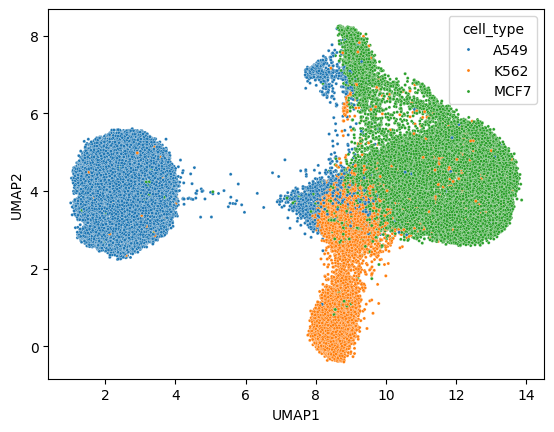

In [10]:
sns.scatterplot(data=adata.obs, x="UMAP1", y="UMAP2", hue="cell_type", s=5)


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

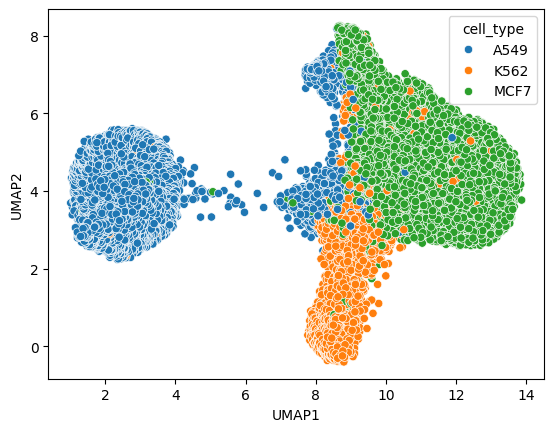

In [11]:
sns.scatterplot(data=adata.obs, x="UMAP1", y="UMAP2", hue="cell_type")
